<a href="https://colab.research.google.com/github/yejinPARK48/VerifyNews_using_Transformer/blob/main/TunedBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Install and Setup

In [3]:
import pandas as pd
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/WELFake_Dataset.csv')
print(data.head())



   Unnamed: 0                                              title  \
0           0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1           1                                                NaN   
2           2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3           3  Bobby Jindal, raised Hindu, uses story of Chri...   
4           4  SATAN 2: Russia unvelis an image of its terrif...   

                                                text  label  
0  No comment is expected from Barack Obama Membe...      1  
1     Did they post their votes for Hillary already?      1  
2   Now, most of the demonstrators gathered last ...      1  
3  A dozen politically active pastors came here f...      0  
4  The RS-28 Sarmat missile, dubbed Satan 2, will...      1  


## 2. Data Loading and Preprocessing

In [4]:

# Check the Data
print(data.head())
print(data.columns)


   Unnamed: 0                                              title  \
0           0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1           1                                                NaN   
2           2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3           3  Bobby Jindal, raised Hindu, uses story of Chri...   
4           4  SATAN 2: Russia unvelis an image of its terrif...   

                                                text  label  
0  No comment is expected from Barack Obama Membe...      1  
1     Did they post their votes for Hillary already?      1  
2   Now, most of the demonstrators gathered last ...      1  
3  A dozen politically active pastors came here f...      0  
4  The RS-28 Sarmat missile, dubbed Satan 2, will...      1  
Index(['Unnamed: 0', 'title', 'text', 'label'], dtype='object')


I have renamed a column because HuggingFace transformers recognize 'labels rather than 'label' as target column name.

In [5]:
data.drop('Unnamed: 0',axis=1,inplace=True)

data.rename(columns={'label':'labels'},inplace=True)

data.head()

,title,text,labels
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [6]:
data.shape

(72134, 3)

In [7]:
# Null values
data.isna().sum()

,0
title,558
text,39
labels,0


In [8]:
# 결측값 제거
data.dropna(subset=['title', 'text'], inplace=True)
data.dropna(axis=0,inplace=True)
# 결과 확인
print(data.shape)
print(data.isna().sum())

(71537, 3)
title     0
text      0
labels    0
dtype: int64


In [9]:
# 중복된 행 개수 확인
print(f"Number of duplicate rows: {data.duplicated().sum()}")

# 중복된 행 제거
data.drop_duplicates(inplace=True)
print(f"Data shape after removing duplicates: {data.shape}")

Number of duplicate rows: 8416
Data shape after removing duplicates: (63121, 3)


In [10]:
# Shuffle the dataframe
data = data.sample(frac=1,random_state=42)

In [11]:
data.head()

,title,text,labels
71361,Donald Trump Responds To Mockery Over Fake Sw...,"Last night, at a rally in Melbourne, Florida, ...",1
11496,Tweetwave,This time it's true no pantsTweetwave More Of ...,1
20292,Rubio says prospect of Trump president is 'wor...,(Reuters) - U.S. Senator Marco Rubio said on W...,0
38855,Trump lifts Cyber Command status to boost cybe...,WASHINGTON (Reuters) - President Donald Trump ...,0
20416,The 7 Biggest Republican Lies About The Econo...,"In two-and-a-half minutes, former U.S. Secreta...",1


## 3. Exploratory Data Analysis

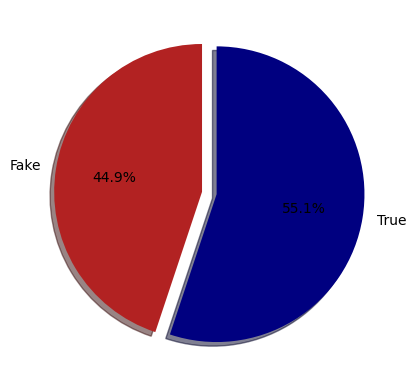

In [12]:
import matplotlib.pyplot as plt

# 데이터 준비
label_size = [data['labels'].sum(), len(data['labels']) - data['labels'].sum()]

# 파이 차트 그리기
plt.pie(label_size,
        explode=[0.1, 0],
        colors=['firebrick', 'navy'],
        startangle=90,
        shadow=True,
        labels=['Fake', 'True'],
        autopct='%1.1f%%')

# 그래프 표시
plt.show()

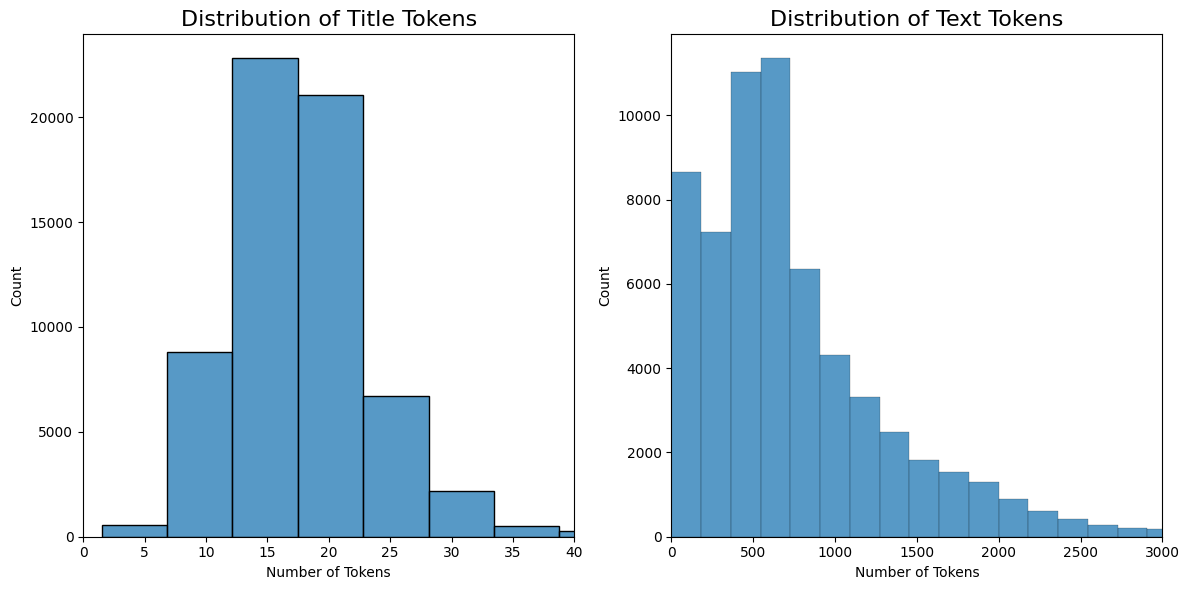

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Token 계산: 각 단어 수에 평균적으로 1.5를 곱해 토큰 수 추정
title_token_counts = data['title'].map(lambda text: len(text.split()) * 1.5)
text_token_counts = data['text'].map(lambda text: len(text.split()) * 1.5)

# 플롯 생성
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 제목 토큰 분포 시각화
sns.histplot(title_token_counts, bins=20, ax=axes[0])
axes[0].set_title("Distribution of Title Tokens", fontsize=16)
axes[0].set_xlabel("Number of Tokens")
axes[0].set_xlim(0, 40)

# 본문 토큰 분포 시각화
sns.histplot(text_token_counts, bins=200, ax=axes[1])
axes[1].set_title("Distribution of Text Tokens", fontsize=16)
axes[1].set_xlabel("Number of Tokens")
axes[1].set_xlim(0, 3000)

# 레이아웃 조정
plt.tight_layout()
plt.show()


The token distribution for titles is more concentrated and smaller in range, making it computationally efficient for model training. On the other hand, the token distribution for texts is broader, indicating higher variability and larger input sizes, which could increase the computational cost when processing with models like BERT.

In [14]:

from transformers import BertTokenizer
import pandas as pd

# 1. 데이터 로드
titles = data['title']

# 2. 텍스트 정제 함수
def clean_text(text):
    # 특수문자 제거
    text = ''.join(c for c in text if c.isalnum() or c.isspace())
    # 소문자 변환
    text = text.lower()
    return text

# 정제된 Title 데이터로 변환
cleaned_titles = titles.apply(clean_text)

# 3. BERT 토크나이저 로드
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# 4. 토큰화, 패딩 및 트렁케이션 처리
max_length = 32  # 고정 시퀀스 길이 설정
encoded_titles = tokenizer(
    cleaned_titles.tolist(),  # 리스트 형태로 변환
    padding='max_length',     # 고정 길이로 패딩
    truncation=True,          # 길이를 초과하면 자름
    max_length=max_length,    # 최대 길이 설정
    return_tensors="pt"       # PyTorch 텐서로 반환 (TensorFlow는 "tf")
)

# 5. 출력 형태 확인
print(encoded_titles.keys())  # 'input_ids', 'attention_mask', 'token_type_ids' 포함
print(encoded_titles['input_ids'][0])  # 첫 번째 샘플의 토큰 ID 출력

# 6. 결과 (PyTorch 텐서) 예시
input_ids = encoded_titles['input_ids']
attention_mask = encoded_titles['attention_mask']




/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
tensor([  101,  6221,  8398, 16412,  2000, 12934,  7301,  2058,  8275,  4467,
         2886,  7374,  2000,  4756,  2115,  1037,  2125,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])


In [15]:
from torch.utils.data import TensorDataset  # TensorDataset 임포트
from sklearn.model_selection import train_test_split
import torch

# 전체 데이터셋 생성
labels = torch.tensor(data['labels'].values)  # 레이블 데이터
dataset = TensorDataset(input_ids, attention_mask, labels)

# 70% Train, 30% Temp (Validation + Test)
train_size = 0.7
train_dataset, temp_dataset = train_test_split(dataset, train_size=train_size)

# Temp 데이터를 50%씩 Validation과 Test로 나눔
val_size = 0.5
val_dataset, test_dataset = train_test_split(temp_dataset, train_size=val_size)

# 확인
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Train dataset size: 44184
Validation dataset size: 9468
Test dataset size: 9469


In [16]:
from torch.utils.data import DataLoader

batch_size = 16  # 배치 크기 설정

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# 확인 (첫 번째 배치)
for batch in train_loader:
    input_ids, attention_mask, labels = batch
    print("Input IDs:", input_ids.shape)
    print("Attention Mask:", attention_mask.shape)
    print("Labels:", labels.shape)
    break


Input IDs: torch.Size([16, 32])
Attention Mask: torch.Size([16, 32])
Labels: torch.Size([16])


In [17]:
from transformers import BertForSequenceClassification
import torch

# BERT 모델 정의
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # 사전학습된 모델
    num_labels=2  # 이진 분류의 경우
)
for param in model.bert.parameters():
    param.requires_grad = False  # BERT 레이어 동결
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [28]:
import torch
from torch.utils.data import DataLoader
from transformers import AdamW, get_scheduler
from sklearn.metrics import accuracy_score  # accuracy_score 함수 가져오기
from tqdm import tqdm

# 설정
epochs = 3
patience = 2

# 옵티마이저 및 스케줄러 설정
optimizer = AdamW(model.parameters(), lr=3e-5, eps=1e-8) #1st Trial: 2e - 5
scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * epochs
)
criterion = torch.nn.CrossEntropyLoss()

# Train 함수 정의
def train(model, train_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc="Training"):
        input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient Clipping
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
    return total_loss / len(train_loader)

# Evaluate 함수 정의
def evaluate(model, val_loader, device):
    model.eval()
    total_loss = 0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating"):
            input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            total_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            val_preds.extend(preds)
            val_labels.extend(labels.cpu().numpy())

    val_accuracy = accuracy_score(val_labels, val_preds)  # 정확도 계산
    return total_loss / len(val_loader), val_accuracy



In [29]:
# 학습 루프
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
best_val_loss = float("inf")
trigger_times = 0

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    # Train
    train_loss = train(model, train_loader, optimizer, scheduler, device)
    print(f"Training Loss: {train_loss:.4f}")

    # Validate
    val_loss, val_accuracy = evaluate(model, val_loader, device)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Early Stopping and Model Saving
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        torch.save(model.state_dict(), "best_model.pth")  # 최적 모델 저장
        print("Best model saved!")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered.")
            break

Epoch 1/3


Training: 100%|██████████| 2762/2762 [01:21<00:00, 33.87it/s]


Training Loss: 0.5370


Validating: 100%|██████████| 592/592 [00:16<00:00, 35.82it/s]


Validation Loss: 0.5139, Validation Accuracy: 0.7602
Best model saved!
Epoch 2/3


Training: 100%|██████████| 2762/2762 [01:18<00:00, 34.98it/s]


Training Loss: 0.5258


Validating: 100%|██████████| 592/592 [00:17<00:00, 34.62it/s]


Validation Loss: 0.5010, Validation Accuracy: 0.7707
Best model saved!
Epoch 3/3


Training: 100%|██████████| 2762/2762 [01:18<00:00, 35.06it/s]


Training Loss: 0.5186


Validating: 100%|██████████| 592/592 [00:16<00:00, 35.71it/s]


Validation Loss: 0.4984, Validation Accuracy: 0.7717
Best model saved!


In [31]:
# 5. 검증
model.eval()
val_preds, val_labels_list = [], []
with torch.no_grad():
    for batch in val_loader:
        input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        val_preds.extend(torch.argmax(logits, axis=1).cpu().numpy())
        val_labels_list.extend(labels.cpu().numpy())

from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(val_labels_list, val_preds)
print(f"Validation Accuracy: {val_accuracy:.4f}")

Validation Accuracy: 0.7717


              precision    recall  f1-score   support

           0       0.72      0.90      0.80      5202
           1       0.83      0.58      0.68      4267

    accuracy                           0.76      9469
   macro avg       0.78      0.74      0.74      9469
weighted avg       0.77      0.76      0.75      9469



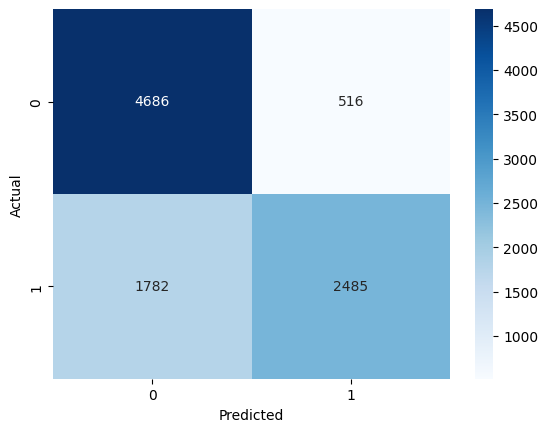

In [32]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 성능 보고서 출력
print(classification_report(test_labels_list, test_preds))

# Confusion Matrix 시각화
cm = confusion_matrix(test_labels_list, test_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
